### Etudiant 1: GIANG Phuong-Thu, Cécile (3530406)
### Etudiant 2: LENOIR Romain (3670199)

# TME 2: Estimation de densité

In [1]:
# Importation du fichier python associé au TME
from tme2 import *

## Visualisation des données

Liste des types de POI furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar

Nous travaillerons avec le point d'intérêt:  clothing_store


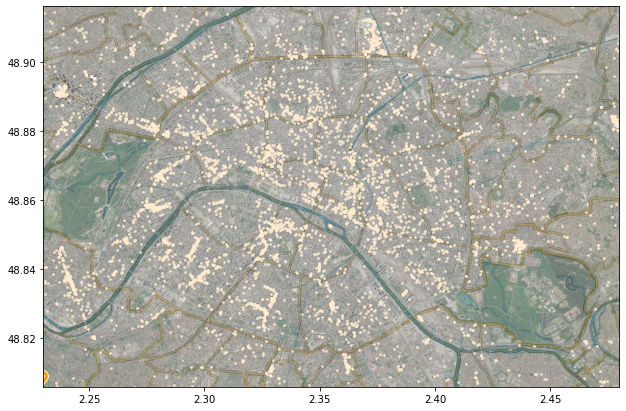

In [2]:
# Affichage des différents types de point of interest (poi)
print("Liste des types de POI" , ", ".join(poidata.keys()))

# Affichage du poi auquel nous nous intéresserons tout le long du TME
print('\nNous travaillerons avec le point d\'intérêt: ', typepoi)

# Affichage de la carte de Paris avec les poi de type `typepoi`
show_poi(geo_mat)

## Explication de la problématique

Dans le cadre de la classification bayésienne, le classifieur cherche à prédire la classe $y$ d'un échantillon $x$ en apprenant la distribution _a posteriori_ de chaque classe de $Y$. En d‘autres termes, il essaie d’estimer la pertinence chacune d'entre elles.

Pour ce faire, il a besoin de la probabilité _a priori_ de chaque $y_i \in Y$, i.e les $p(Y = y_i)$, ainsi que de la vraisemblance de l'échantillon $x$ selon chaque classe, i.e les $p(x|y)$. Ainsi, la classe choisie sera celle qui maximise la probabilité _a posteriori_ :

$$ p(y|x) = \frac{p(x|y) p(y)}{p(x)} $$

Bien qu'il soit le meilleur classifieur possible, il pose un problème majeur: la valeur de la vraisemblance $p(x|y)$ est rarement disponible...

Deux solutions s'offrent à nous:
* essayer d'estimer $p(x|y)$, en supposant l'indépendance entre les attributs par exemple _(naive bayes)_
* ... ou en s'en affranchissant

Cela peut se faire en estimant la densité de probabilité de l'échantillon $x$ par deux méthodes: la méthode des histogrammes ou la méthode d'estimation de densité par noyau.

Dans la suite, l’objectif sera d’estimer la loi de densité $p(x, y)$ géographique des POIs sur Paris, où $x$ et $y$ sont les coordonnées GPS d’un lieu. Pour rappel, nous avons choisi de nous fixer aux magasins de vêtements.

## Estimation de densité: méthode des histogrammes

Le problème s'énonce très simplement: on dispose d'un échantillon $x = (x_1, ..., x_n)$ de taille $n$ d'une loi à densité $f$ inconnue. Que peut-on dire de $f$ à partir de cet échantillon ?

L'estimation de densité par histogramme est très simple dans notre cadre: comme notre étude porte simplement sur les coordonnées géographiques des POIs, il s'agit de compter le nombre de magasins de vêtements dans une certaine zone géographique. Pour cela, nous divisons notre image en $t \times t$ cases, où $t$ est notre pas de discrétisation: autrement dit nous la transformons en une grille sur laquelle nous effectuons un comptage des magasins dans chaque case.

Nous avons implémenté une classe `Histogram_Model`, prenant en argument le nombre d'intervalles `bins` par axe. La méthode `train` compte simplement les échantillons pour chaque case de la grille. La méthode `predict`, elle, renvoie la densité pour chaque case de la grille, calculée à partir de leurs effectifs.

Il y aura donc `bins x bins` cases dans la map. Plus `bins` sera grand, plus le nombre de cases sera élevé et donc le pas de discrétisation sera petit.

Dans les affichages ci-dessous, les points blancs représentent les POIs (magasins de vêtements) dans Paris, tandis que chaque zone (case de la grille) sera coloriée selon sa densité (couleur claire: forte densité, couleur sombre: faible densité).

**Test de `Histogram_Model`, pour `bins = 2`**

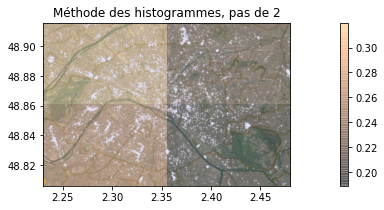

In [4]:
show_density_Hist(geo_mat, 2)

Pour un pas de discrétisation trop grand (`bins` trop petit), la densité calculée dans la grille n'est pas significative: elle est calculée sur des zones trop grandes de la map et ne donne qu'un aperçu global et imprécis de la répartition des échantillons. On est en **sous-apprentissage**.

**Test de `Histogram_Model`, pour `bins = 8`**

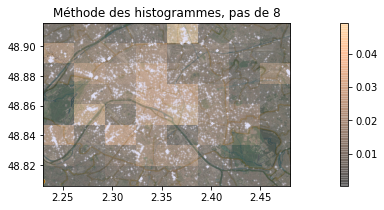

In [5]:
show_density_Hist(geo_mat, 8)

Ce pas de discrétisation semble convenir pour nos échantillons. La map des densités montre clairement quelles zones sont riches en magasins de vêtements (particulièrement le centre de Paris) et quelles zones sont désertes (banlieue, sud-ouest de Paris).

**Test de `Histogram_Model`, pour `bins = 20`**

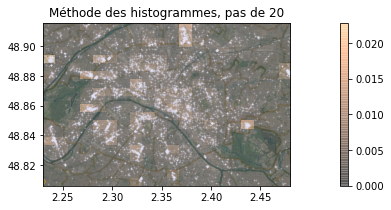

In [6]:
show_density_Hist(geo_mat, 20)

Cette fois-ci, notre pas de discrétisation est trop petit (`bins` trop grand). La densité calculée dans la grille n'est pas représentative: elle est calculée sur de trop petites zones de la map, pour laquelle l'effectif est en général nul. On est en **sur-apprentissage**.

## Estimation de densité: méthode à noyaux

Plutôt que de décider d’une discrétisation a priori, l’estimation est faite en centrant une
fenêtre autour du point d’intérêt $x_0$ (dans un espace de dimension $d$), et pour $n$ exemples (échantillon de taille $n$).

Soit $R_n$ l'hypercube centré en $x_0$, dont chaque côté est de longueur $h_n$. $V_n = h_n^d$ est donc le volume de l'hypercube.

On note $p(x_0)$ la densité à estimer, et $\phi$ une fonction (Parzen ou noyau). Alors $p(x_0)$ vaut:

$$ p_n(x_0) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{V_n} \phi\bigg(\frac{x_0 - x_i}{h_n}\bigg) $$


Les points d'intérêt seront pour nous les points de la grille `grid`.

### Fonctions $\phi$

La fonction $\phi$ la plus courante est celle de Parzen, qui est la fonction indicatrice de l'hypercube unitaire.

$$
\phi(x) = \left\{
    \begin{array}{ll}
        1 & \mbox{si } |x^i| \leq 1/2 \\
        0 & \mbox{sinon.}
    \end{array}
\right.
$$

Cependant, rien ne nous oblige à nous limiter à des hypercubes. De manière générale, nous pouvons prendre $\phi$ une fonction noyau: une telle fonction nous permet de pondérer différemment selon la distance au point d'estimation.

Dans notre cas, nous testerons le noyau gaussien ainsi que le noyau de Laplace:

$$\phi_{Gauss}(x) = \frac{1}{\sqrt{2 \pi}} e^{- \frac{1}{2} x^2}$$

$$\phi_{Laplace}(x) = \frac{1}{2} e^{-|x|}$$

Nous avons implémenté une classe `KDE_Model`, prenant en argument `h` (paramètre _fenêtre_) qui régit le degré de lissage de la fonction $\phi$, `noyau` qui peut définit la fonction prise par $\phi$ (`parzen`, `gauss` ou `laplace`), et enfin le nombre d'intervalles `steps` par axe de la grille. 

La méthode `predict`, renvoie la densité pour chaque case de la grille.

Il y aura donc `steps x steps` cases dans la grille. Plus `steps` sera grand, plus le nombre de cases sera élevé et donc le pas de discrétisation sera petit.

Dans les affichages ci-dessous, les points blancs représentent les POIs (magasins de vêtements) dans Paris, tandis que chaque zone (case de la grille) sera coloriée selon sa densité (couleur claire: forte densité, couleur sombre: faible densité).

**Test de `KDE_Model` avec noyau de Parzen, pour `steps` croissant et `h = 0.05`**

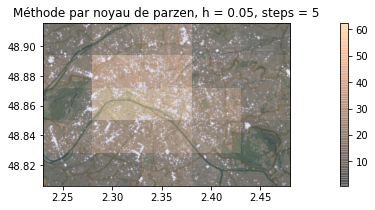

In [7]:
show_density_KDE(geo_mat, 0.05, 'parzen', 5) # Sous-apprentissage

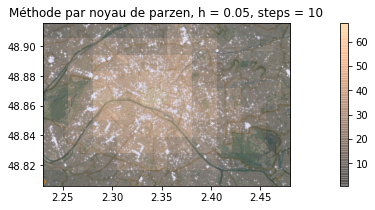

In [4]:
show_density_KDE(geo_mat, 0.05, 'parzen', 10) # Bon apprentissage

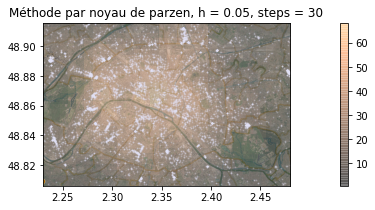

In [6]:
show_density_KDE(geo_mat, 0.05, 'parzen', 30) # Sur-apprentissage

**Test de `KDE_Model` avec noyau de Parzen, pour `h` croissant et `steps = 10`**

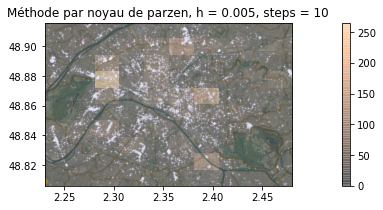

In [7]:
show_density_KDE(geo_mat, 0.005, 'parzen', 10) # pas assez lissé, ne prend en compte que la case courante

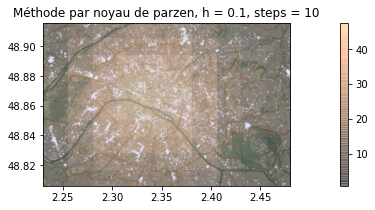

In [8]:
show_density_KDE(geo_mat, 0.1, 'parzen', 10) # lissage convenable

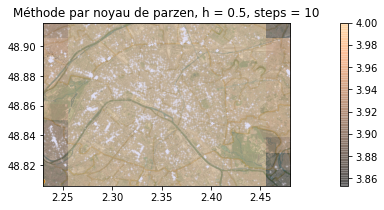

In [10]:
show_density_KDE(geo_mat, 0.5, 'parzen', 10) # beaucoup trop lissé

**Tests avec Parzen, le noyau gaussien et le noyau laplacien pour `steps = 10` et `h = 0.085`**

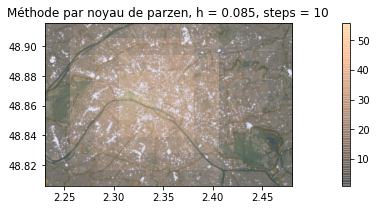

In [11]:
# Avec Parzen
show_density_KDE(geo_mat, 0.085, 'parzen', 10)

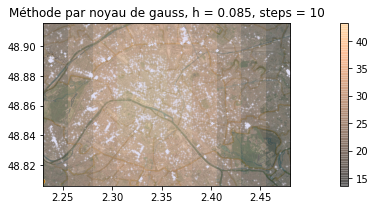

In [12]:
# Avec le noyau gaussien
show_density_KDE(geo_mat, 0.085, 'gauss', 10)

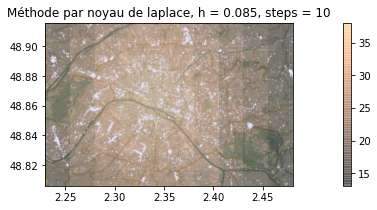

In [13]:
# Avec le noyau laplacien
show_density_KDE(geo_mat, 0.085, 'laplace', 10)

Pour choisir les meilleurs paramètres `steps` et `h`, il faudrait tester les modèles ci-dessus en faisant varier leurs valeurs. On prendra ceux qui maximisent la vraisemblance maximale pour un rayon infiniment petit, sachant que la vraisemblance s'écrit, pour un échantillon $E = \{x_i\}_{i=1}^{N}$ de taille $N$:

$$ L(\theta, E) = p_{\theta}(E) = \prod\limits_{i=1}^N p_{\theta}(x_i) $$

## Vérification des modèles par histogramme et par noyaux avec d'autres types de POIs

Testons maintenant les deux méthodes d'estimation de densité avec d'autres types de POIs cette fois-ci.
Prenons par exemple les types `home_goods_store` et `restaurant`.

**Test pour `typepoi = home_goods_store`**

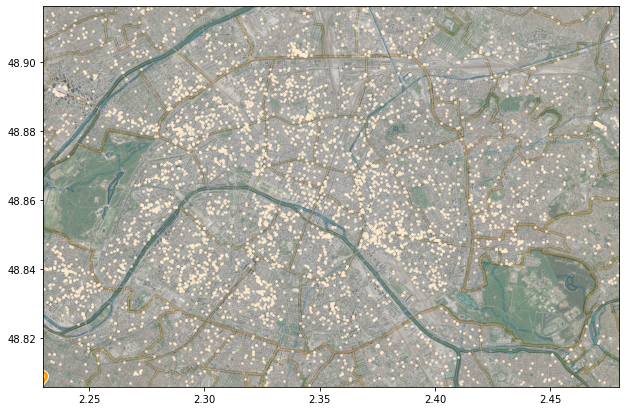

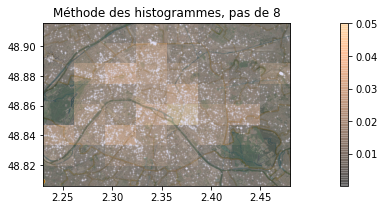

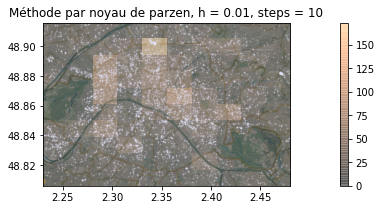

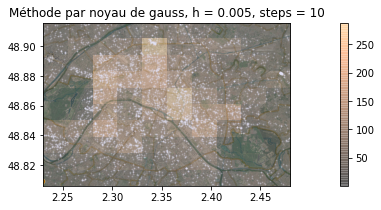

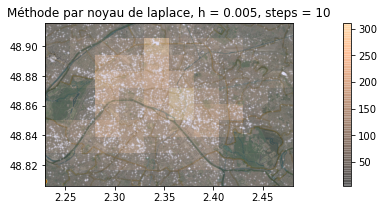

In [14]:
## Choix d'un poi
typepoi = "home_goods_store"

## Creation de la matrice des coordonnees des POI
geo_mat = np.zeros((len(poidata[typepoi]), 2))
for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0]

# Affichage des POIs
show_poi(geo_mat)

# Estimation de la densité par histogramme
show_density_Hist(geo_mat, 8)

# Estimation de la densité par noyau: Parzen
show_density_KDE(geo_mat, 0.01, 'parzen', 10)

# Estimation de la densité par noyau: Gauss
show_density_KDE(geo_mat, 0.005, 'gauss', 10)

# Estimation de la densité par noyau: Laplace
show_density_KDE(geo_mat, 0.005, 'laplace', 10)

Le modèle semble assez bien correspondre à ce qui est attendu.

**Tests pour `typepoi = restaurants`**

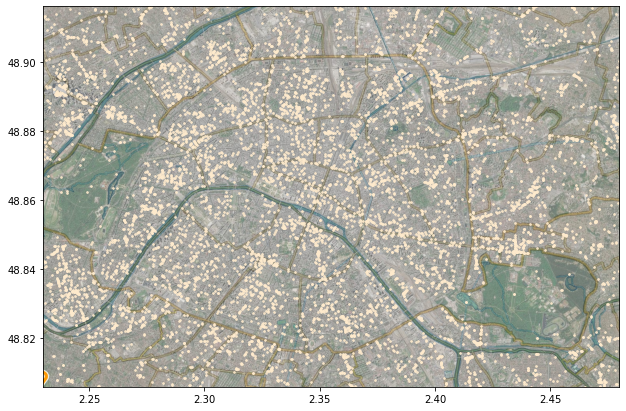

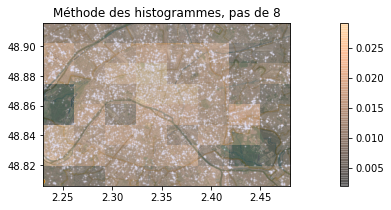

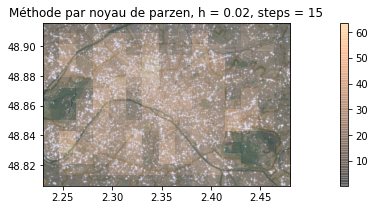

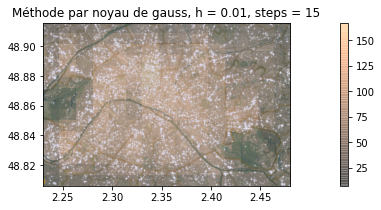

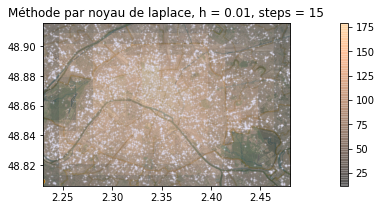

In [17]:
## Choix d'un poi
typepoi = "restaurant"

## Creation de la matrice des coordonnees des POI
geo_mat = np.zeros((len(poidata[typepoi]), 2))
for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0]

# Affichage des POIs
show_poi(geo_mat)

# Estimation de la densité par histogramme
show_density_Hist(geo_mat, 8)

# Estimation de la densité par noyau: Parzen
show_density_KDE(geo_mat, 0.02, 'parzen', 15)

# Estimation de la densité par noyau: Gauss
show_density_KDE(geo_mat, 0.01, 'gauss', 15)

# Estimation de la densité par noyau: Laplace
show_density_KDE(geo_mat, 0.01, 'laplace', 15)

## Classifieur bayésien

### 1- Estimateur de Nadaraya-Watson

Maintenant que nous avons calculé la vraisemblance $p(x|y)$, il nous est désormais possible d'utiliser un classifieur bayésien.

La **régression par noyau** est une méthode non-paramétrique permettant d'estimer l'espérance conditionnelle d'une variable aléatoire.

L'espérance conditionnelle de la v.a. $Y$ conditionnellement à la v.a. $X$ peut s'écrire:

$$ E(Y|X) = m(X) $$

... où $m$ est une fonction (dite _estimateur_ ).

Nous nous intéressons en particulier à **l'estimateur de Nadaraya-Watson**, qui s'écrit pour un certain $y$:

$$ m_h(x,y) = p(y|x) = \frac{\sum_{i | y_i = y} \phi\big( \frac{x - x_i}{h} \big)}{\sum_{i} \phi\big( \frac{x - x_i}{h} \big)} $$

La classe choisie sera alors le $y$ maximisant cette valeur.

**Prédiction de la note d'un magasin de vêtements en fonction de sa localisation géographique:**

In [9]:
## Choix d'un poi
typepoi = "clothing_store"

## Creation de la matrice des coordonnees des POI (on rajoute cette fois les notes)
geo_mat = np.zeros((len(poidata[typepoi]), 3))
for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,0] = v[0][0]
    geo_mat[i,1] = v[0][1]
    geo_mat[i,2] = v[1]

## Les données d'entraînement seront les POIs qui sont notés
data_train = np.array([v for v in geo_mat if v[2]!=-1])

## Les données de test seront les POIs qui sont ne sont pas notés (-1)
data_test = np.array([v for v in geo_mat if v[2]==-1])

## Prédiction des notes sur les données d'apprentissage
model = Nadaraya_Watson(data_train, 'gauss', 0.005)
notes_train_NW = model.predict(data_train)

print('Notes prédites pour data_train: \n', notes_train_NW)
print('\nNotes réelles pour data_train: \n', data_train[ : , 2])

print('\nErreur de prédiction moyenne : ', np.sum(np.abs(notes_train_NW - data_train[ : , 2])) / len(notes_train_NW))

Notes prédites pour data_train: 
 [4.20891067 3.96167859 3.91891587 ... 4.0722546  4.04977401 4.05995563]

Notes réelles pour data_train: 
 [4.6 3.8 4.1 ... 5.  3.9 3.1]

Erreur de prédiction moyenne :  0.7106238235684478


In [10]:
## Prédiction des notes sur les données de test
model = Nadaraya_Watson(data_train, 'gauss', 0.005)
notes_test_NW = model.predict(data_test)

print('Notes prédites pour data_test: \n', notes_test_NW)

Notes prédites pour data_test: 
 [4.04497973 4.20107701 4.12146802 ... 4.09311988 3.89853843 3.14656188]


### 2- K plus proches voisins (KNN)

Plutôt que de prendre en compte un noyau ou une distance, nous nous intéressons au voisinage (immédiat ou non) de chaque point de l'échantillon: pour un exemple $x = (x_1, ..., x_d)$, nous sélectionnons ses $k$ plus proches voisins et moyennons leur note pour en déduire une prédiction de la note de $x$.

In [11]:
## Prédiction des notes sur les données d'apprentissage
model = KNN(data_train, 10)
notes_train_KNN = model.predict(data_train)

print('Notes prédites pour data_train: \n', notes_train_KNN)
print('\nNotes réelles pour data_train: \n', data_train[ : , 2])

print('\nErreur de prédiction moyenne : ', np.sum(np.abs(notes_train_KNN - data_train[ : , 2])) / len(notes_train_KNN))

Notes prédites pour data_train: 
 [4.46 3.59 3.8  ... 4.36 4.47 4.13]

Notes réelles pour data_train: 
 [4.6 3.8 4.1 ... 5.  3.9 3.1]

Erreur de prédiction moyenne :  0.6937596508895603


In [12]:
## Prédiction des notes sur les données de test
model = KNN(data_train, 10)
notes_test_KNN = model.predict(data_test)

print('Notes prédites pour data_test: \n', notes_test_KNN)

Notes prédites pour data_test: 
 [4.5  4.42 4.37 ... 4.28 3.8  3.19]


**Différence de prédiction moyenne entre `Nadaraya-Watson` et `KNN` sur les données de test `data_test`:**

In [13]:
print('Différence de prédiction moyenne : ', np.sum(np.abs(notes_train_KNN - notes_train_NW)) / len(notes_train_KNN))

Différence de prédiction moyenne :  0.2066002650040507


Les résultats obtenus par les deux méthodes sont assez proches.